generate conffile

In [6]:
multnamearr = range(10,91,20)
multstrarr = ["0 1 15","0 1 5","0 1 3","0 7 15","0 3 5"]
rtnamearr = ["ecmp","su2"]
rt1arr = ["ecmp","su"]
rt2arr = [0,2]
pwnamearr = ["equal","thisweight"]
fseedarr = range(10)

for imult,multname in enumerate(multnamearr):
    multstr = multstrarr[imult]

    lfarr = [2,20,204]
    with open(f"/home/annzhou/DRing/src/emp/datacentre/experiments/linkfailure/leafspine_{multname}.conf",'w') as f:
        rtname = "ecmp"
        rt1 = "ecmp"
        rt2 = 0
        pwname = "equal"
        pwfile = f"pathweightfiles/leafspine/{rtname}/pathweight_leafspine_{rtname}_equal_64.txt"

        f.write(f"./run.sh LEAFSPINE MAKE 80 3072 64 leafspine_a2a A2A null {multstr} 0 0 0 0 0 0 {rt1} {rt2} null 0 netpathfiles/netpath_{rtname}_leafspine.txt {pwfile} 64 50 150 200 0 0 > m_linkfailure_leafspine_{rtname}_a2a_{pwname}_{multname}_0_0.log\n")
        for lf in lfarr:
            for fseed in fseedarr:
                f.write(f"./run.sh LEAFSPINE NOMAKE 80 3072 64 leafspine_a2a A2A null {multstr} 0 0 0 0 0 0 {rt1} {rt2} null 0 netpathfiles/netpath_{rtname}_leafspine.txt {pwfile} 64 50 150 200 {lf} {fseed} > m_linkfailure_leafspine_{rtname}_a2a_{pwname}_{multname}_{lf}_{fseed}.log\n")

    lfarr = [2,21,213]
    with open(f"/home/annzhou/DRing/src/emp/datacentre/experiments/linkfailure/dring_{multname}.conf",'w') as f:
        make_dring = True
        for irtname,rtname in enumerate(rtnamearr):
            rt1 = rt1arr[irtname]
            rt2 = rt2arr[irtname]
            for pwname in pwnamearr:
                pwfile = f"pathweightfiles/dring/{rtname}/a2a/pathweight_pbr1_dring_{rtname}_a2a_lp1_barriernocrossover_64.txt" if pwname=="thisweight" else f"pathweightfiles/dring/{rtname}/pathweight_dring_{rtname}_equal_64.txt"
                make = "MAKE" if make_dring else "NOMAKE"
                f.write(f"./run.sh RRG {make} 80 2988 64 dring_a2a A2A graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 0 0 0 0 0 0 {rt1} {rt2} null 0 netpathfiles/netpath_{rtname}_dring.txt {pwfile} 64 50 150 200 0 0 > m_linkfailure_dring_{rtname}_a2a_{pwname}_{multname}_0_0.log\n")
                make_dring = False

                for lf in lfarr:
                    for fseed in fseedarr:
                        f.write(f"./run.sh RRG NOMAKE 80 2988 64 dring_a2a A2A graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 0 0 0 0 0 0 {rt1} {rt2} null 0 netpathfiles/netpath_{rtname}_dring.txt {pwfile} 64 50 150 200 {lf} {fseed} > m_linkfailure_dring_{rtname}_a2a_{pwname}_{multname}_{lf}_{fseed}.log\n")

generate picklefile

In [ ]:
import pickle

homedir = "/home/annzhou"
conffilesuffix = ["leafspine_50","leafspine_70"]
for suffix in conffilesuffix:
    print(suffix)
    conffile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure/{suffix}.conf"
    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure/{suffix}.txt"
    datadict = dict()
    with open(conffile,'r') as f:
        with open(sumfile,'a') as sumf:
            lines = f.readlines()
            for line in lines:
                tokens = line.split()
                logfile = tokens[31]
                sizelist = list()
                durationlist = list()
                startlist = list()
                with open(f"{homedir}/DRing/src/emp/datacentre/{logfile}",'r') as logf:
                    print(logfile)
                    loglines = logf.readlines()
                    for logline in loglines:
                        logtokens = logline.split()
                        if logtokens[0] == "FCT":
                            durationlist.append(float(logtokens[2]))
                            sizelist.append(int(logtokens[1]))
                            startlist.append(float(logtokens[3]))
                datadict[logfile] = [durationlist,sizelist,startlist]
                durationlist.sort()
                sumf.write(f"{logfile}\t{sum(durationlist)/len(durationlist)}\t{durationlist[int(len(durationlist)*0.5)]}\t{durationlist[int(len(durationlist)*0.99)]}\t{durationlist[int(len(durationlist)*0.9999)]}\n")

    with open(f'/home/annzhou/DRing/src/emp/datacentre/experiments/linkfailure/{suffix}.pickle', 'wb') as handle:
        pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot

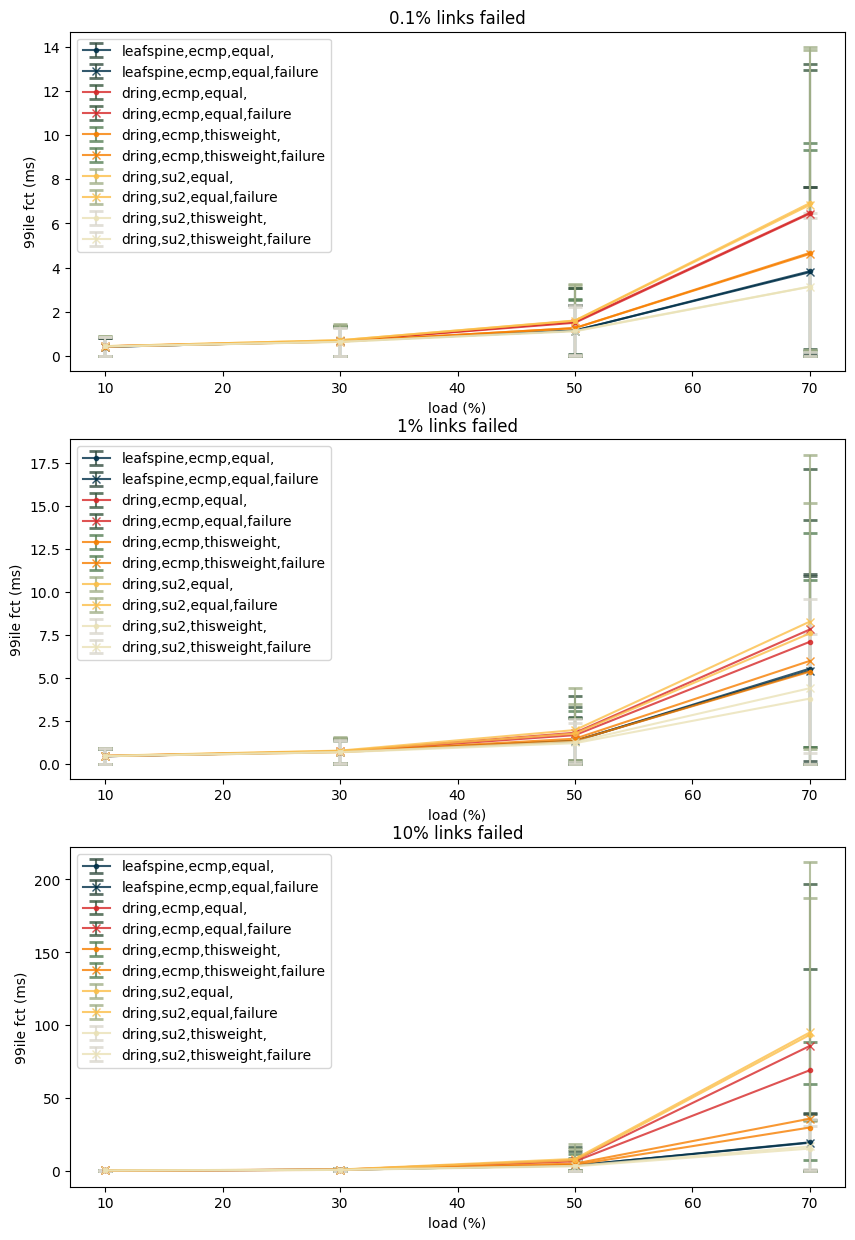

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

homedir = "/home/annzhou"
fig,axs = plt.subplots(3,1,figsize=(10,15))
loadarr = range(10,71,20)
dringnumfaillinkarr = [2,21,213]
leafspinenumfaillinkarr = [2,20,204]

plottitlenamelist = ["0.1%","1%","10%"]
plotcolordict = {"leafspine,ecmp,equal":"#003049","dring,ecmp,equal":"#d62828","dring,ecmp,thisweight":"#f77f00","dring,su2,equal":"#fcbf49","dring,su2,thisweight":"#eae2b7"}
plotecolordict = {"leafspine,ecmp,equal":"#344e41","dring,ecmp,equal":"#3a5a40","dring,ecmp,thisweight":"#588157","dring,su2,equal":"#a3b18a","dring,su2,thisweight":"#dad7cd"}
plotmarkerdict = {"":'.',"failure":"x"}

for i in range(3):
    for topology,routing in [["leafspine","ecmp"],["dring","ecmp"],["dring","su2"]]:
        if topology=="leafspine":
            numfaillink = leafspinenumfaillinkarr[i]
            pwnamearr = ["equal"]
        elif topology=="dring":
            numfaillink = dringnumfaillinkarr[i]
            pwnamearr = ["equal","thisweight"]
        for pwname in pwnamearr:
            for failname in ["","failure"]:
                if failname=="":
                    fseedarr = [0]
                elif failname=="failure":
                    fseedarr = range(10)
                fctarr = list()
                for load in loadarr:
                    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure/{topology}_{load}.txt"
                    # print(sumfile)
                    fctallfseedarr = list()
                    with open(sumfile,'r') as f:
                        lines = f.readlines()
                        for fseed in fseedarr:
                            logfile = f"m_linkfailure_{topology}_{routing}_a2a_{pwname}_{load}_{numfaillink}_{fseed}.log"
                            # print(logfile)
                            for line in lines:
                                tokens = line.split()
                                if logfile==tokens[0]:
                                    fctallfseedarr.append(float(tokens[3]))
                    fctarr.append(fctallfseedarr)
                plotname = f"{topology},{routing},{pwname}"
                axs[i].errorbar(loadarr,[sum(l)/len(l) for l in fctarr],yerr=[[min(l) for l in fctarr],[max(l) for l in fctarr]], color=plotcolordict[plotname], ecolor=plotecolordict[plotname], capsize=5, capthick=2, label=f"{plotname},{failname}",marker=plotmarkerdict[failname],alpha=0.8)
                axs[i].legend()
                axs[i].set_xlabel('load (%)')
                axs[i].set_ylabel('99ile fct (ms)')
                axs[i].set_title(f'{plottitlenamelist[i]} links failed')
plt.show()

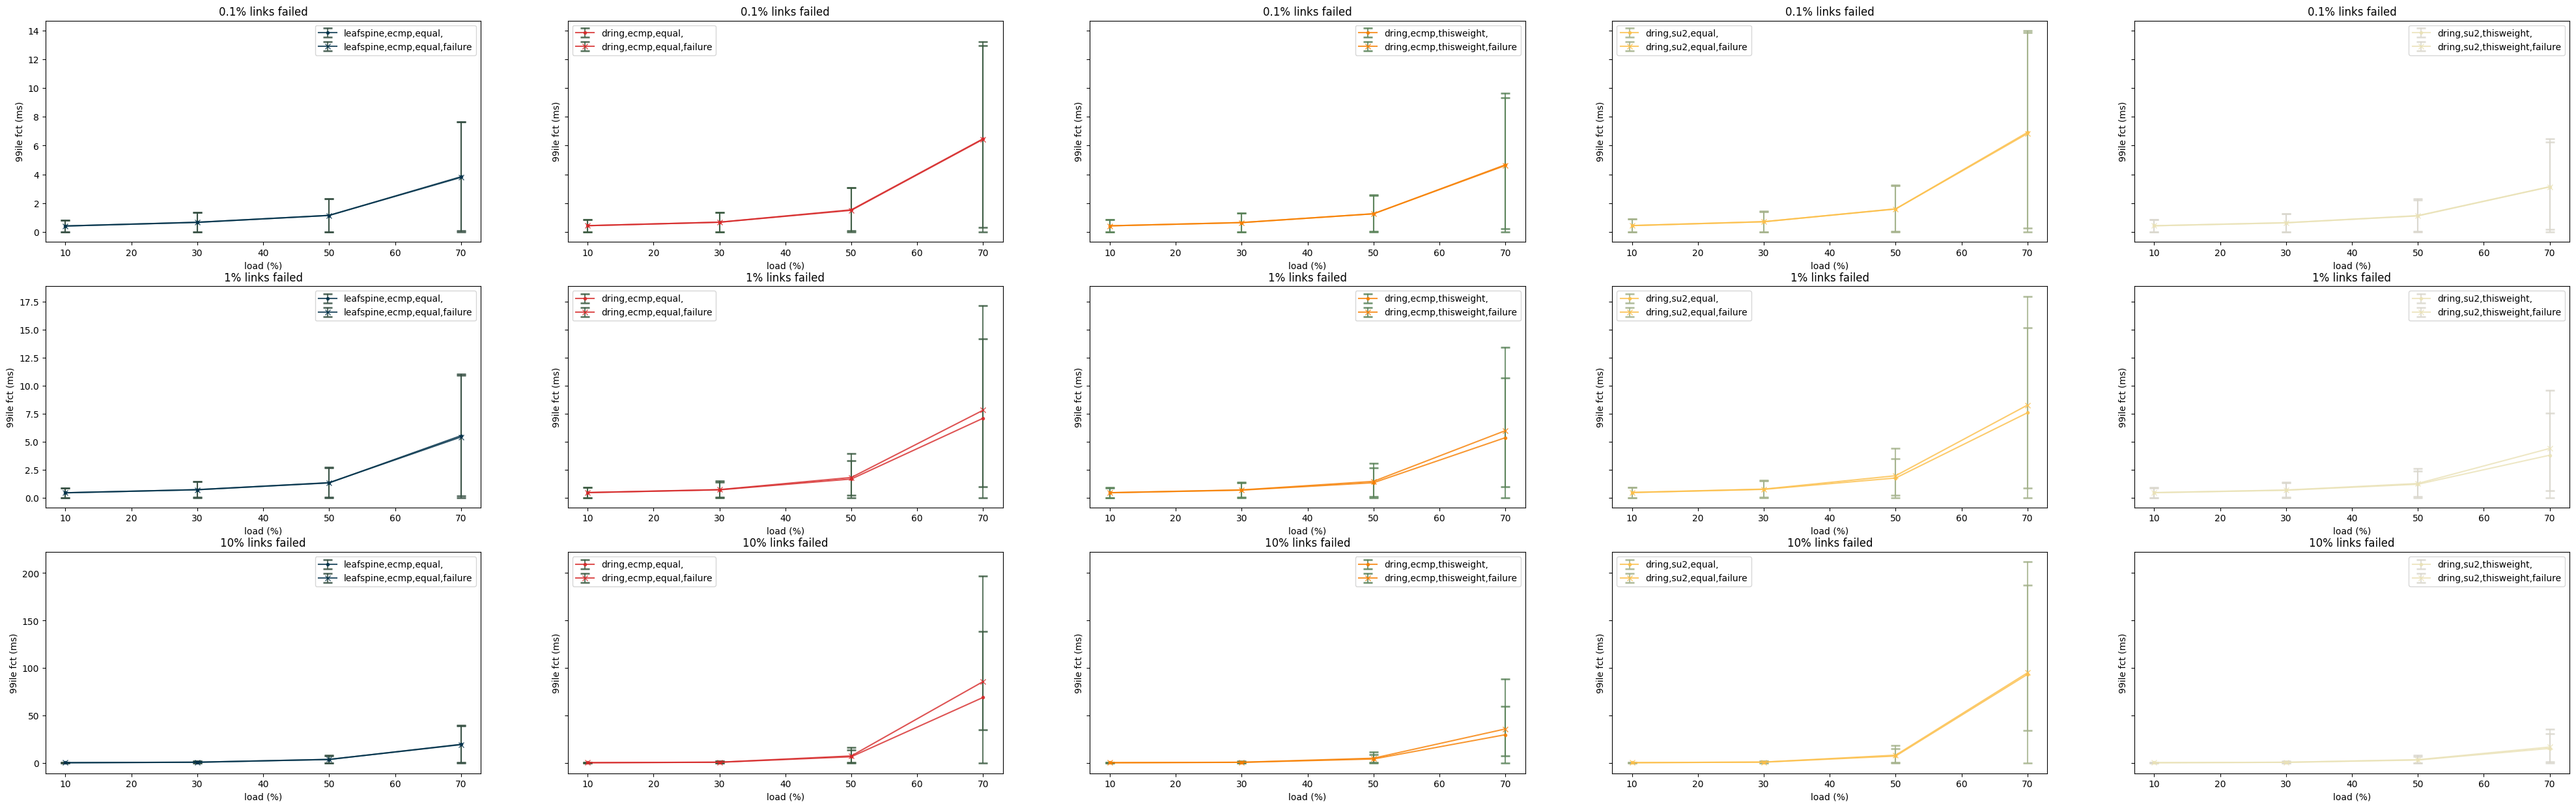

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

homedir = "/home/annzhou"
fig,axs = plt.subplots(3,5,figsize=(50,15),sharey='row')
loadarr = range(10,71,20)
dringnumfaillinkarr = [2,21,213]
leafspinenumfaillinkarr = [2,20,204]

plottitlenamelist = ["0.1%","1%","10%"]
plotcolordict = {"leafspine,ecmp,equal":"#003049","dring,ecmp,equal":"#d62828","dring,ecmp,thisweight":"#f77f00","dring,su2,equal":"#fcbf49","dring,su2,thisweight":"#eae2b7"}
plotecolordict = {"leafspine,ecmp,equal":"#344e41","dring,ecmp,equal":"#3a5a40","dring,ecmp,thisweight":"#588157","dring,su2,equal":"#a3b18a","dring,su2,thisweight":"#dad7cd"}
plotmarkerdict = {"":'.',"failure":"x"}
plotnumberdict = {"leafspine,ecmp,equal":0,"dring,ecmp,equal":1,"dring,ecmp,thisweight":2,"dring,su2,equal":3,"dring,su2,thisweight":4}

for i in range(3):
    for topology,routing in [["leafspine","ecmp"],["dring","ecmp"],["dring","su2"]]:
        if topology=="leafspine":
            numfaillink = leafspinenumfaillinkarr[i]
            pwnamearr = ["equal"]
        elif topology=="dring":
            numfaillink = dringnumfaillinkarr[i]
            pwnamearr = ["equal","thisweight"]
        for pwname in pwnamearr:
            for failname in ["","failure"]:
                if failname=="":
                    fseedarr = [0]
                elif failname=="failure":
                    fseedarr = range(10)
                fctarr = list()
                for load in loadarr:
                    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure/{topology}_{load}.txt"
                    # print(sumfile)
                    fctallfseedarr = list()
                    with open(sumfile,'r') as f:
                        lines = f.readlines()
                        for fseed in fseedarr:
                            logfile = f"m_linkfailure_{topology}_{routing}_a2a_{pwname}_{load}_{numfaillink}_{fseed}.log"
                            # print(logfile)
                            for line in lines:
                                tokens = line.split()
                                if logfile==tokens[0]:
                                    fctallfseedarr.append(float(tokens[3]))
                    fctarr.append(fctallfseedarr)
                plotname = f"{topology},{routing},{pwname}"
                plotnumber = plotnumberdict[plotname]
                axs[i,plotnumber].errorbar(loadarr,[sum(l)/len(l) for l in fctarr],yerr=[[min(l) for l in fctarr],[max(l) for l in fctarr]], color=plotcolordict[plotname], ecolor=plotecolordict[plotname], capsize=5, capthick=2, label=f"{plotname},{failname}",marker=plotmarkerdict[failname],alpha=0.8)
                axs[i,plotnumber].legend()
                axs[i,plotnumber].set_xlabel('load (%)')
                axs[i,plotnumber].set_ylabel('99ile fct (ms)')
                axs[i,plotnumber].set_title(f'{plottitlenamelist[i]} links failed')
plt.show()

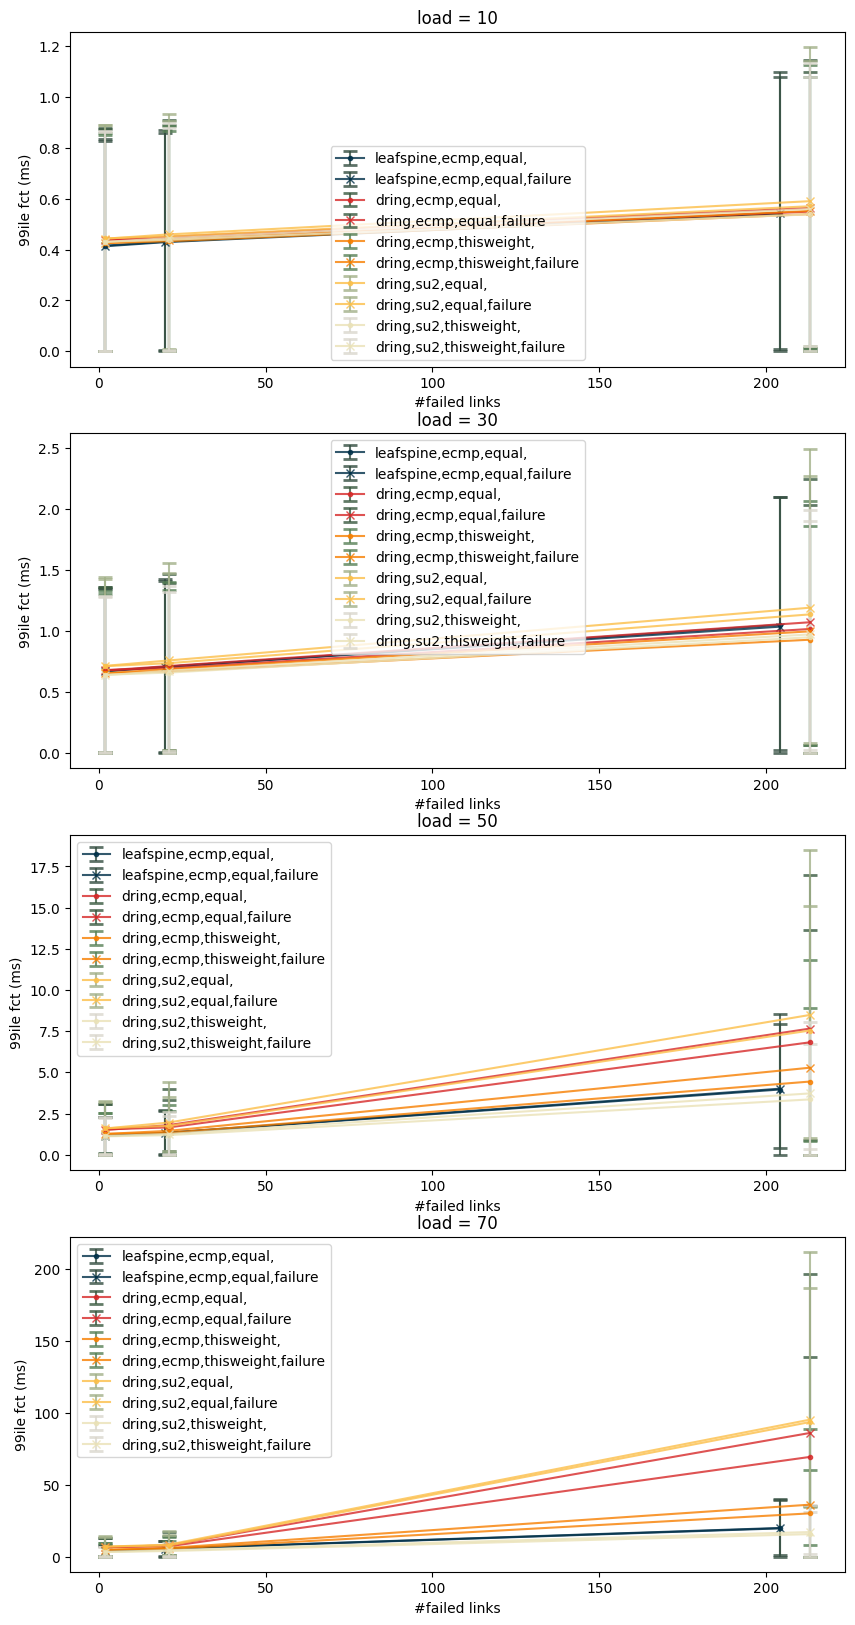

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

homedir = "/home/annzhou"
fig,axs = plt.subplots(4,1,figsize=(10,20),sharey='row')
loadarr = range(10,71,20)
dringnumfaillinkarr = [2,21,213]
leafspinenumfaillinkarr = [2,20,204]

plottitlenamelist = ["0.1%","1%","10%"]
plotcolordict = {"leafspine,ecmp,equal":"#003049","dring,ecmp,equal":"#d62828","dring,ecmp,thisweight":"#f77f00","dring,su2,equal":"#fcbf49","dring,su2,thisweight":"#eae2b7"}
plotecolordict = {"leafspine,ecmp,equal":"#344e41","dring,ecmp,equal":"#3a5a40","dring,ecmp,thisweight":"#588157","dring,su2,equal":"#a3b18a","dring,su2,thisweight":"#dad7cd"}
plotmarkerdict = {"":'.',"failure":"x"}
plotnumberdict = {"leafspine,ecmp,equal":0,"dring,ecmp,equal":1,"dring,ecmp,thisweight":2,"dring,su2,equal":3,"dring,su2,thisweight":4}

for i in range(4):
    load = loadarr[i]
    for topology,routing in [["leafspine","ecmp"],["dring","ecmp"],["dring","su2"]]:
        if topology=="leafspine":
            numfaillinkarr = leafspinenumfaillinkarr
            pwnamearr = ["equal"]
        elif topology=="dring":
            numfaillinkarr = dringnumfaillinkarr
            pwnamearr = ["equal","thisweight"]
        for pwname in pwnamearr:
            for failname in ["","failure"]:
                if failname=="":
                    fseedarr = [0]
                elif failname=="failure":
                    fseedarr = range(10)
                fctarr = list()
                for numfaillink in numfaillinkarr:
                    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure/{topology}_{load}.txt"
                    # print(sumfile)
                    fctallfseedarr = list()
                    with open(sumfile,'r') as f:
                        lines = f.readlines()
                        for fseed in fseedarr:
                            logfile = f"m_linkfailure_{topology}_{routing}_a2a_{pwname}_{load}_{numfaillink}_{fseed}.log"
                            # print(logfile)
                            for line in lines:
                                tokens = line.split()
                                if logfile==tokens[0]:
                                    fctallfseedarr.append(float(tokens[3]))
                    fctarr.append(fctallfseedarr)
                plotname = f"{topology},{routing},{pwname}"
                plotnumber = plotnumberdict[plotname]
                # axs[i,plotnumber].errorbar(numfaillinkarr,[sum(l)/len(l) for l in fctarr],yerr=[[min(l) for l in fctarr],[max(l) for l in fctarr]], color=plotcolordict[plotname], ecolor=plotecolordict[plotname], capsize=5, capthick=2, label=f"{plotname},{failname}",marker=plotmarkerdict[failname],alpha=0.8)
                # axs[i,plotnumber].legend()
                # axs[i,plotnumber].set_xlabel('#failed links')
                # axs[i,plotnumber].set_ylabel('99ile fct (ms)')
                # axs[i,plotnumber].set_title(f'load = {load}')
                axs[i].errorbar(numfaillinkarr,[sum(l)/len(l) for l in fctarr],yerr=[[min(l) for l in fctarr],[max(l) for l in fctarr]], color=plotcolordict[plotname], ecolor=plotecolordict[plotname], capsize=5, capthick=2, label=f"{plotname},{failname}",marker=plotmarkerdict[failname],alpha=0.8)
                axs[i].legend()
                axs[i].set_xlabel('#failed links')
                axs[i].set_ylabel('99ile fct (ms)')
                axs[i].set_title(f'load = {load}')
plt.show()

delete logfile

In [17]:
import os

homedir = "/home/annzhou"
conffile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure/dring_10.conf"
with open(conffile,'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split()
        logfile = tokens[31]
        os.remove(f"{homedir}/DRing/src/emp/datacentre/{logfile}")

delete log & run

In [ ]:
import os

homedir = "/home/annzhou"
dringdir = f"{homedir}/DRing/src/emp/datacentre"
for filedir in os.listdir(dringdir):
    if os.path.isfile(os.path.join(dringdir, filedir)):
        tokens = filedir.split("_")
        if (tokens[0]=="rrg" or tokens[0]=="leafspine") and tokens[1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[-1]=="run") and ((tokens[0]=="leafspine" and tokens[1]=="leafspine") or (tokens[0]=="rrg" and (tokens[1]=="rrg" or tokens[1]=="dring"))):
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")


parse test conf

In [3]:
# test
homedir = "/home/annzhou/"
conffile = f"{homedir}DRing/src/emp/datacentre/experiments/linkfailure/test.conf"
sumfile = f"{homedir}DRing/src/emp/datacentre/experiments/linkfailure/test.txt"
datadict = dict()
with open(conffile,'r') as f:
    with open(sumfile,'a') as sumf:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            logfile = tokens[31]
            sizelist = list()
            durationlist = list()
            startlist = list()
            with open(f"{homedir}DRing/src/emp/datacentre/{logfile}",'r') as logf:
                loglines = logf.readlines()
                for logline in loglines:
                    logtokens = logline.split()
                    if logtokens[0] == "FCT":
                        durationlist.append(float(logtokens[2]))
                        sizelist.append(int(logtokens[1]))
                        startlist.append(float(logtokens[3]))
            datadict[logfile] = [durationlist,sizelist,startlist]
            durationlist.sort()
            sumf.write(f"{logfile}\t{sum(durationlist)/len(durationlist)}\t{durationlist[int(len(durationlist)*0.5)]}\t{durationlist[int(len(durationlist)*0.99)]}\t{durationlist[int(len(durationlist)*0.9999)]}\n")

aux: does dring+su2+weighted outperform leafspine in A2A?

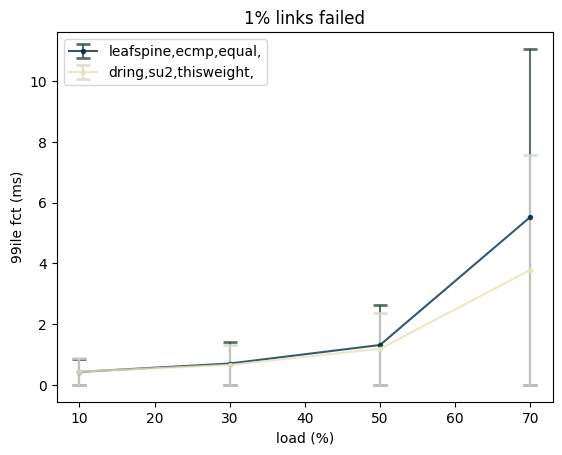

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

homedir = "/home/annzhou"
loadarr = range(10,71,20)
dringnumfaillinkarr = [21]
leafspinenumfaillinkarr = [20]

plottitlenamelist = ["1%"]
plotcolordict = {"leafspine,ecmp,equal":"#003049","dring,ecmp,equal":"#d62828","dring,ecmp,thisweight":"#f77f00","dring,su2,equal":"#fcbf49","dring,su2,thisweight":"#eae2b7"}
plotecolordict = {"leafspine,ecmp,equal":"#344e41","dring,ecmp,equal":"#3a5a40","dring,ecmp,thisweight":"#588157","dring,su2,equal":"#a3b18a","dring,su2,thisweight":"#dad7cd"}
plotmarkerdict = {"":'.',"failure":"x"}

i=0
for topology,routing in [["leafspine","ecmp"],["dring","su2"]]:
    if topology=="leafspine":
        numfaillink = leafspinenumfaillinkarr[i]
        pwnamearr = ["equal"]
    elif topology=="dring":
        numfaillink = dringnumfaillinkarr[i]
        pwnamearr = ["thisweight"]
    for pwname in pwnamearr:
        for failname in [""]:
            if failname=="":
                fseedarr = [0]
            elif failname=="failure":
                fseedarr = range(10)
            fctarr = list()
            for load in loadarr:
                sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure/{topology}_{load}.txt"
                # print(sumfile)
                fctallfseedarr = list()
                with open(sumfile,'r') as f:
                    lines = f.readlines()
                    for fseed in fseedarr:
                        logfile = f"m_linkfailure_{topology}_{routing}_a2a_{pwname}_{load}_{numfaillink}_{fseed}.log"
                        # print(logfile)
                        for line in lines:
                            tokens = line.split()
                            if logfile==tokens[0]:
                                fctallfseedarr.append(float(tokens[3]))
                fctarr.append(fctallfseedarr)
            plotname = f"{topology},{routing},{pwname}"
            plt.errorbar(loadarr,[sum(l)/len(l) for l in fctarr],yerr=[[min(l) for l in fctarr],[max(l) for l in fctarr]], color=plotcolordict[plotname], ecolor=plotecolordict[plotname], capsize=5, capthick=2, label=f"{plotname},{failname}",marker=plotmarkerdict[failname],alpha=0.8)
            plt.legend()
            plt.xlabel('load (%)')
            plt.ylabel('99ile fct (ms)')
            plt.title(f'{plottitlenamelist[i]} links failed')
# plt.ylim(0,2)
plt.show()